# Explainer Notebook

# COVID-19 in Germany

Victor Fertin(s164508), Theis Gregersen(s160691), Katja Salskov-Iversen(s144549)




## 1. Motivation

The 2019 Novel Coronavirus (COVID-19) continues to spread in countries around the world. This project is concerning the spread of the virus in Germany. The data sources are obtained from Kaggle and contain number of reported cases, deaths and recoveries in Germany on the federal state (Bundesland) and county (Landkreis/Stadtkreis) level. Furthermore the latitude and longtitude coordinates are found for each state and merged with the dataset. 

The reason for choosing these particular dataset, is because Germany was amongst the most affected countries worldwide, while also a part of the once that did the most COVID-19 tests in the beginning of the spread  ([Reference](https://www.euronews.com/2020/03/27/germany-increases-its-covid-19-tests-to-500-000-per-week)) . This was a choice made by the group when the project started 31/3/2020. However, these facts have change at the current date. Now Germany has declared “fragile intermediate success”. This declaration makes it interesting to investigate the choices and regulations that Germany has made to assure slowing the spread. 



First, all the used packages are loaded: 

In [1]:
import pandas as pd
import numpy as np

import datetime as dt
import warnings
from random import sample 
warnings.filterwarnings('ignore')
import matplotlib.animation as animation
import matplotlib.ticker as ticker

import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#Plotly
import plotly.graph_objects as go
import plotly.offline as py

# bokeh basics
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, output_file, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.transform import dodge

#Folium 
import folium
from folium.plugins import HeatMap
from folium import plugins

from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

# Displaying html
from IPython.display import HTML
from IPython.display import IFrame

# Solver for SEIR model
from scipy.integrate import odeint

Now the data from Kaggle and the location data is loaded, merged and presented to give an overview of the data:

In [2]:
df_covid1 = pd.read_csv("data/covid_de.csv")
df_demo = pd.read_csv("data/demographics_de.csv")
df_des = pd.read_excel("data/location.xlsx")

#drop NaN and change to datetime
df_covid = df_covid1.dropna()
df_covid['date'] = pd.to_datetime(df_covid.date)


#Changing gender in demografic to have same values as covid data set. 
df_demo['gender'] = df_demo['gender'].map({'female': 'F','male':'M'})


#Merging the two dataset on state, age_group and gender. 
merged = pd.merge(df_covid,df_demo,how='inner', on=["state","age_group","gender"])
#And merging latitude and longtitude on the full dataset
df = pd.merge(merged,df_des,how='inner',on=['county'])
df['date'] = pd.to_datetime(df.date)
df = df[~(df['date'] < '2020-01-27')]
#We make a table that is grouped by date for statistical analysis
df_date=df.groupby('date').sum()


df

,state,county,age_group,gender,date,cases,deaths,recovered,population,Lat,Lon
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-27,1,0,1,261674,48.465000,9.761111
1,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-28,1,0,1,261674,48.465000,9.761111
2,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-04-03,1,0,1,261674,48.465000,9.761111
3,Baden-Wuerttemberg,LK Alb-Donau-Kreis,05-14,F,2020-03-17,1,0,1,490822,48.465000,9.761111
4,Baden-Wuerttemberg,LK Alb-Donau-Kreis,05-14,F,2020-03-25,1,0,1,490822,48.465000,9.761111
...,...,...,...,...,...,...,...,...,...,...,...
67851,Thueringen,SK Suhl,60-79,F,2020-04-17,1,0,1,297754,50.609111,10.694009
67852,Thueringen,SK Suhl,60-79,M,2020-03-24,1,1,0,264189,50.609111,10.694009
67853,Thueringen,SK Suhl,60-79,M,2020-03-28,1,1,0,264189,50.609111,10.694009
67854,Thueringen,SK Suhl,60-79,M,2020-04-15,1,0,1,264189,50.609111,10.694009


The dataset contains 11 attributes and 67655 observations. 

The merged dataset contains COVID data in general (state, country, age_group, gender, date, cases, deaths and recovered), demographic data (population by state, gender and age_group), and finally location (lat, lon). The three datasets are chosen to get an overview of the spread in general, but also to investigate if the virus spread more in certain areas or if a specific group of people are more likely to catch the virus. 

The goal is to make the end user aware of the virus spread in Germany and the importance of the government’s regulations in regards to slowing the spread. 


## 2. Basic stats

### Data cleaning

When collecting the data, we started by observing the number of null values in the dataset. 



In [3]:
for column in df_covid1:
    if df_covid1[column].isnull().any():
       print('{0} has {1} null values'.format(column, df_covid1[column].isnull().sum()))

age_group has 162 null values
gender has 375 null values


(OBS: The data cleaning and preprocessing code is shown in 1. Motivation)

This show us, that some of the data is insufficient, because of the null values. It is decided to remove these nulls since it is a low amount of rows, hence it should not be relevant to the outcome of the analysis. 

Furthermore the attribute "date" is converted to date time. To be able to merge the data sets, the values in the gender attribute has to be changed to F and M describing the two gender.

Finally the three dataset are merged. 

An overview of the key statistics are shown below. The statistics take stand in df_date, where the dataset is grouped by date, which gives an overview of registred cases, deaths and recoveries per day in all off Gernamny. 

In [4]:
df_date[['cases','recovered','deaths']].describe()

,cases,recovered,deaths
count,83.000000,83.000000,83.000000
mean,1962.012048,1621.313253,82.144578
std,1981.807850,1904.375725,103.115390
min,1.000000,1.000000,0.000000
25%,66.000000,37.000000,0.000000
50%,1418.000000,830.000000,27.000000
75%,3309.000000,2959.500000,146.500000
max,6546.000000,6142.000000,366.000000


Key point to take away from this overview is that the median of all three attributes are relatively low compared to max. This tells us, that most days smaller amount of cases, deaths and recovered were registered. This can be of many reasons, one of them being that the country decided to test a lot in one or two days, but not consistently over many days. Further investigation is necessary. 

In [5]:
# this overview is of covid data only.
df_covid.describe(include='object')

,state,county,age_group,gender
count,67856,67856,67856,67856
unique,16,412,6,2
top,Bayern,SK Muenchen,35-59,F
freq,17276,564,22663,34278


This lilte overview show that there are 16 staets in Germany, 412 counties, 6 age groups and 2 genders. 

The rest of the stats are difficult to draw any fast conclusions from, since they are considered in both number of cases, deaths and recoveries. This should be further investigated before any conclusion.

Following is an overview of the distribution of number of cases and recoveries overall in Germany, when grouping the data by date. 

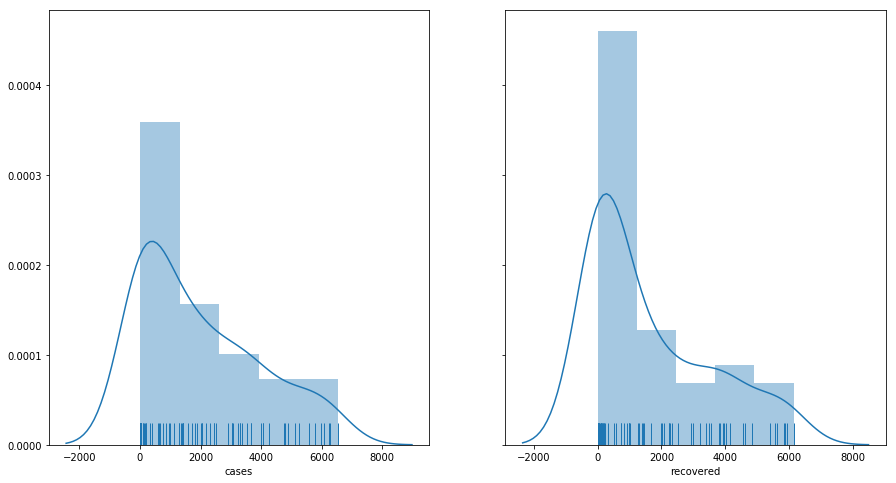

In [6]:
#We start by making four plots on the same run. 
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15, 8))

sns.distplot(df_date.cases, rug=True, ax=ax1)
sns.distplot(df_date.recovered, rug=True, ax=ax2)
# sns.distplot(df_date.deaths, rug=True, ax=ax3)

In [7]:
#Checking for the skew value.
df_date[['cases','recovered','deaths']].skew()

cases        0.778293
recovered    0.990543
deaths       1.182449
dtype: float64

The two distributions are alike, which makes good sence - the more confirmed cases, the more confirmed recovered. 

Furthermore we see the clear tendensy that we also saw in the summary, where most days only a few new cases or recoveries are confirmed. Both distributions are positive skewed, and the skew value of deaths is even larger. 


The next plot will show the correlation between cases, deaths and recoveries: 


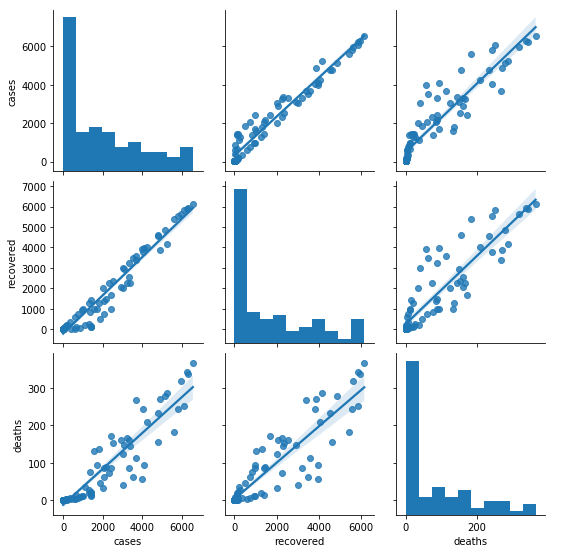

In [8]:
sns.pairplot(df_date[['cases','recovered','deaths']], kind="reg")

The pairplot show, as expected, a possitive correlation between the the three attributes -> the more confirmed cases, the more deaths, and also more confirmed recoveries. It is hard to compare recovered and deaths, since you cannot recover after dying. However, because they are borh correlated with number of cases, they too are correlated. 

## 3. Data analysis

The data analysis was initiated by exploring the overall development of recorded cases, deaths and recoveries in Germany. From investigating the different parameters, it was deduced that there on average is recorded 2.4 cases of new infected across counties, gender and age groups. For recorded deaths and recoveries this was approximately 0.1 and 2.0 respectively.

In [9]:
df_covid.describe()

,cases,deaths,recovered
count,67856.000000,67856.000000,67856.000000
mean,2.399906,0.100477,1.983170
std,2.871071,0.398526,2.778219
min,0.000000,0.000000,-1.000000
25%,1.000000,0.000000,1.000000
50%,1.000000,0.000000,1.000000
75%,3.000000,0.000000,2.000000
max,69.000000,10.000000,68.000000


From the plot below it is ascertained that Germany has four observations with more than 60 recorded new infected within one age group, one county and either female or male. And as mentioned above, the observations are centering around the lower number of cases. Note that the y-axis has been log-scaled.

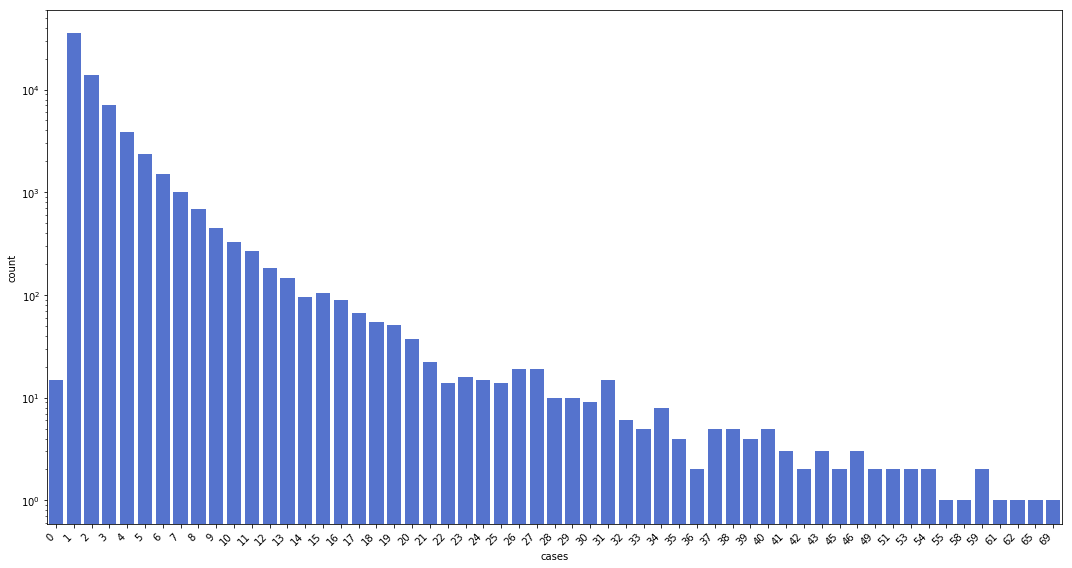

In [10]:
plt.figure(figsize=(15,8))
chart = sns.countplot(df_covid['cases'],color = 'royalblue')
chart.set_yscale('log')

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.show()

From looking at the distribution of gender it was deduced that Germany experienced more recorded cases for females than for males, which were quite surprising because the reverse was expected. However, it also showed that the death rate is higher for men, which is consistent with the impression that was given by the media; that the COVID-19 strikes men harder than women. 

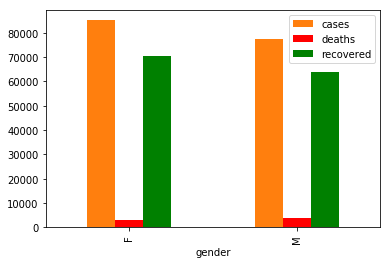

In [11]:
dd = df.groupby('gender').sum()
dd.drop(['population','Lat','Lon'],axis=1).plot(kind='bar',color =['C1','red','green'])

By investigating the distribution among the different age groups, it was identified that the most recorded cases are within the age group of 35 to 59. Not particularly surprising since this age group has the highest contribution to the population of Germany. Additionally, the same investigation revealed, that the age groups from 60 onwards has the highest amount of deaths and 80 to 99 taking the dull lead.

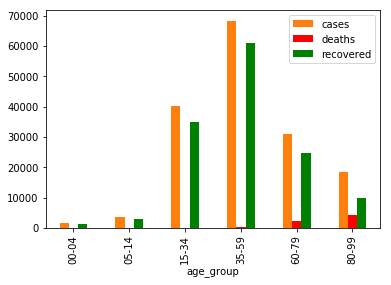

In [12]:
dd = df.groupby('age_group').sum()
dd.drop(['population','Lat','Lon'],axis=1).plot(kind='bar',color =['C1','red','green'])

When studying the spread of COVID-19 across the country it was made clear that Bayern is one of the most severely affected states in Germany and was likewise this state that had the first recorded case of COVID-19. As illustrated in the race bar chart on the webpage it is only Nordrhein-Westfalen and Baden-Württemberg that are experiencing the same amount of cases.  

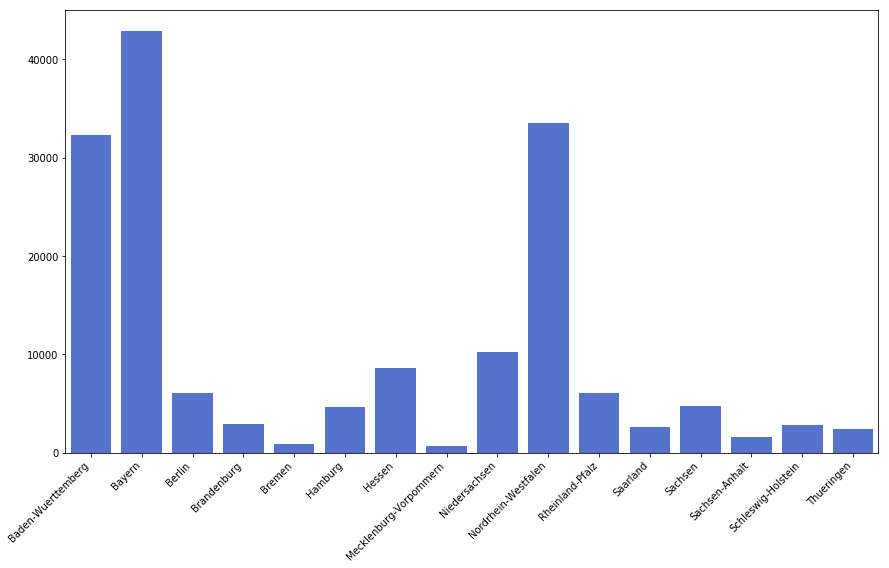

In [13]:
dd = df.groupby('state').sum()
plt.figure(figsize=(12.5,8))
#chart = sns.barplot(data = dd, x= dd.index ,y=dd.cases.values, palette = 'Blues_r')
chart = sns.barplot(x= df_covid['state'].unique() ,y=df_covid.groupby('state')['cases'].sum().values, color = 'royalblue')

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.show()

However, these numbers are not taken the total population within each state into account. When doing so Bayern and Baden-Württemberg are still the two states that are most affected, but Nordrhein-Westfalen are only the fifth worse and the states Saarland and Hamburg are now the third and fourth worse states regarding most recorded cases.

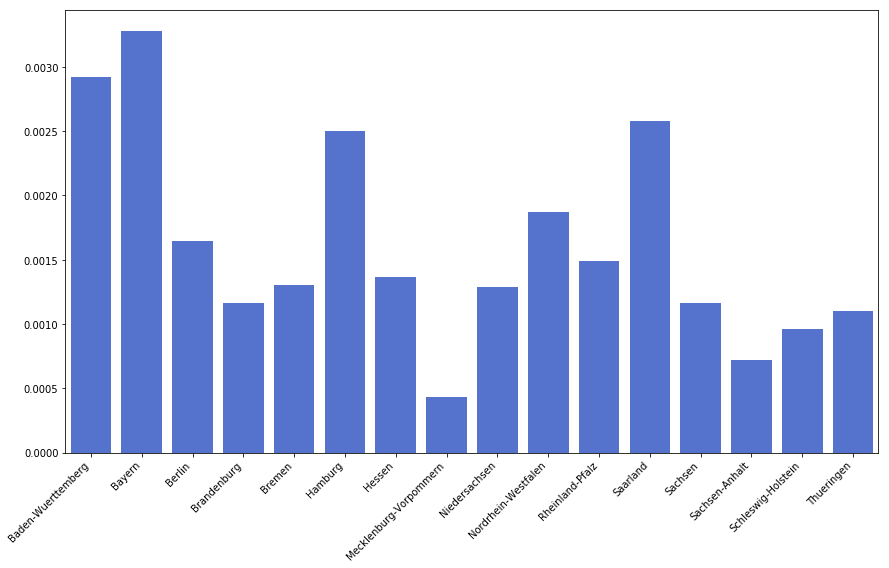

In [14]:
plt.figure(figsize=(12.5,8))
chart = sns.barplot( x= df_covid['state'].unique(),y=df_covid.groupby('state')['cases'].sum().values/df_demo.groupby('state')['population'].sum().values, color = 'royalblue')

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.show()

By conducting a heatmap it was clearly illustrated that the spread is centering around the densely populated areas, which also makes perfect sense. This visualisation will be presented later.

By exploring the development of recorded cases, death and recoveries over time and within each state or county and gender or age group a nascent story was slowly taking its form and an idea of what would be interesting to incorporate in the explanatory visualisations were initiated.

## 4. Genre

The genre of this project is in the philosiphi of a slideshow, where the typical slideshow format makes it author-driven but where the interaction opportunities are reader-driven, and for each slide the discovery of the data is up to the reader. However, the slideshow genre is build up as a web page format, where the reader scroll down instead of scrolling to the next page. This genre works well because it allow the aouther to walk the user through data-dimensions and manipulations step-bystep. This ensures that the user only moves forward in the presentation when he/she is ready to do so, and allows the user to stop and interact with the visuals if needed (cite:Narrative Visualization: Telling Stories with Data, section 4-5). 

Looking at *The Design space analysis*, this project has used following Visual narratives: 

<u>Visual Structuring:</u>
* Establishing shot\
An establishing shot is used to introduce the scen of the visualization. This allows us to manipulate a scene to direct attention to a point of interest. 
* Progress Bar / Timeline # OBS: DENNE KAN VI VÆLGE AT HAVE MED? KONSTANT VISE HVOR LANGT VI ER I FREMLÆGGELSEN? 
* "Checklist Progress Tracker #OBS SAMME MED DENNE... 

<u>Highlighting:</u> 
* Motion \ VED IKKE HELT HVAD DENNE ER
* Colors\
Specific colors are used to try and allorcate the users attention to specific areas or important points in the visualization and around in the slideshow.
* Zooming \
Interactive zooming is possible in some visualizations to allow the reader to dive into the data, if eks. he/she wants to look closer on the map and the registred cases in Germany. 

<u>Transition guidance:</u> 
* 

And following narrative structure:

<u>Ordering:</u>
* Linear\
The narrative of the slideshow is lineary. This is chosen because the story that is told is aouther-driven, and because we want to tell the story step by step, to inform the user as much as possible in the correct order. 

<u>Interactivity:</u>
* Hover highlighting\
It is chosen to include hover highlighting since it encourages the reader to be interactive with the visualization, and allow the curious reader to get details-on-demand, without too much explaining text is confusing the slideshow. 
* Filtering, selection\
Filtering is creating the same as hovering, but on the same time it allows the reader to dive into the data and play around, without anyone determining the agenda.
* Stimulation defaul views\
These are provided to the reader and are ment to be a jumping off points for further exploration. \

<u>Messaging:</u>

The following are used to communicate observations to the reader: 

* Captions and headlines\
All the visualizations have headlines since it gives an overview and makes it easier for the reader to interpret the data.
* Annotations\
These are used to tell key observations from the data. 

* Introductory text\
As the project is in the genre of a slideshow, a short presentation of each "slide" is used, to help the reader get the most out of the visualizations. 

* Summary\
Summary is used to make sure that the reader leaves the presentation on the right page, and has gotten all the correct information. 


## 5. Visualization

In the following section the visualisations will be sourced directly from the webpage, because they won’t render properly with running the code. So, for you to being able to see all of the visualisations without having to run all of the codes (one of them takes more than an hour to run), the codes will be followed by the html embedded visualisations. 

The webpage is carried by its visualizations. First we give some “Big Ass Numbers” to give the reader an overview of COVID-19 cases, deaths and recoveries, both overall and by 1 million inhabitant. 

### OVERSKRIFT

The following code generates a heatmap, indicating which states are more severely affect.

In [ ]:
# Adding latitude and longitude to states
state_loc = pd.DataFrame(np.array([
['Baden-Wurttemberg',48.99999229,8.999993448],
['Bayern',49.26660748,10.96660681],
['Berlin',52.52181866,13.40154862],
['Brandenburg',51.7704175,13.72996741],
['Bremen',53.05043805,8.779982461],
['Hamburg',53.55002464,9.999999144],
['Hessen',50.30000694,9.200029662],
['Mecklenburg Vorpommern',53.63330408,12.41669861],
['Niedersachsen',52.1299986,9.720004434],
['Nordrhein Westfalen',51.52998822,8.030011351],
['Rheinland Pfalz',49.58247246,7.703219156],
['Saarland',49.25039044,6.970003213],
['Sachsen',50.82998395,12.91997595],
['Sachsen Anhalt',52.13042137,11.62000362],
['Schleswig Holstein',54.28374778,9.433315388],
['Thuringen',50.97005292,11.02996212]]),columns=['State','Lat','Long'])
state_loc = state_loc.sort_values('State')

In [ ]:
# Add total cases to df_des
df_des['Total Cases']= df.groupby('county')['cases'].sum().values

# Create new dataframe 
df_county = df_des[['county','Lat','Lon']]

# Add rows equal to total cases pr. county
for i in range(df_des.shape[0]):
    df_county=df_county.append([df_county[i:i+1]]*(df_des['Total Cases'][i]-1))

In [ ]:
# The two plots together 


#A new map is defined: 
map_DE_heat=folium.Map([51.2, 9.8], zoom_start=6,tiles='Stamen Toner')

# Ensureing that the data is float
df_county['Lon'] = df_county['Lon'].astype(float)
df_county['Lat'] = df_county['Lat'].astype(float)

# Filter the DataFrame for columns, so only latitude and longtitude is remaining 
heat_df = df_county[['Lat', 'Lon']]

# List comprehension to make out list of lists
heat_data = [[row['Lat'],row['Lon']] for index, row in heat_df.iterrows()]

# Plot it on the map. 
#The parameter radius is set to 20 meters and the max_zoom level to 20 for the tile layer that is created.
HeatMap(data=heat_data,radius=20, max_zoom=20).add_to(map_DE_heat)


state_loc['Total Cases'] = df.groupby('state')['cases'].sum().values
state_loc['Total Deaths'] = df.groupby('state')['deaths'].sum().values
state_loc['Total Recovered'] = df.groupby('state')['recovered'].sum().values

for i in range(state_loc.shape[0]):
    icon = folium.Icon(color="red")
    folium.Marker([state_loc['Lat'][i],state_loc['Long'][i]],
                  tooltip='<b>State: {} <br>' 'Total Cases: {} <br>' 'Total Deaths: {}<br>' 'Total Recovered: {}'.format(state_loc['State'][i],state_loc['Total Cases'][i],state_loc['Total Deaths'][i],state_loc['Total Recovered'][i]),icon=icon).add_to(map_DE_heat)




# Display the map
map_DE_heat




This visualisation shows the total number of infected indicated by the intensity of the heatmap. Furthermore, by hovering over the markers an information box will pop up and tell the total numbers of cases, recovered and deaths and in which state. This provides an opportunity for the reader to interact and only get the information of the states they find relevant or of interest.

In [64]:
#Called from the repository
IFrame(src='https://theisgregersen.github.io/Covid-19-DE/heatmap_DE.html', width=900, height=600)

The following figure shows how the virus is distributed among gender and age groups.

In [ ]:
pyramid_data = df.groupby(['gender','age_group']).sum()

women_case = pyramid_data.cases.F.values*-1
men_case = pyramid_data.cases.M.values
women_deaths = pyramid_data.recovered.F.values*-1
men_deaths = pyramid_data.recovered.M.values


y = [1,2,3,4,5,6]


age = ['00-04','05-14', '15-34','35-59','60-79',   '80-99']
layout = go.Layout(yaxis=go.layout.YAxis(title='Age',
                                        tickvals=[1,2,3,4,5,6],
                                        ticktext=age),
                   xaxis=go.layout.XAxis(
                       range=[-40000, 40000],
                       tickvals=[-35000,-20000,-10000,-5000,0,5000,10000,20000,35000],
                       ticktext=[35000,20000,10000,5000,0,5000,10000,20000,35000],
                       title='Occurences'),
                   barmode='overlay',
                   bargap=0.1,
                  
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    margin=go.layout.Margin(
        l=100, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=15  #top margin
    ))
fig = go.Figure(layout=layout)
fig.add_trace(go.Bar(y=y,
               x=men_case,
               orientation='h',
               name='Men Cases',
               text = men_case,
               hoverinfo='text',
               opacity=0.8,
               marker=dict(color='#78AAC8')
               ))

fig.add_trace(go.Bar(y=y,
               x=men_deaths,
               orientation='h',
               name='Men Recoveries',
               text = men_deaths,
               hoverinfo='text',
               opacity=0.8,
               marker=dict(color='#3E618C')
               ))

fig.add_trace(go.Bar(y=y,
               x=women_case,
               orientation='h',
               name='Women Cases',
               text=-1 * women_case,
               hoverinfo='text',
               opacity=0.8,
               marker=dict(color='#FFA2A9')
               ))

fig.add_trace(go.Bar(y=y,
               x=women_deaths,
               orientation='h',
               name='Women Recoveries',
               text=-1 * women_deaths,
               hoverinfo='text',
               opacity=0.8,
               marker=dict(color='#E0585F')
               ))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='grey')
fig.update_layout(hovermode='y')
fig.show()
#fig.write_html("Pyramid.html")

In [65]:
#Called from the repository
IFrame(src='https://theisgregersen.github.io/Covid-19-DE/Pyramid.html', width=900, height=500)

The final visualisation in the general overview shows the different death rates for women and men between the different age groups and it can be deduced that the death rate in general are higher for men, except for the age group 80-99. The y-axis has been log-scaled so it is possible to see the bars for age groups with a lower death rate. This can at first glance by a bit misleading, which is why it is noted in the webpage that the real values can be achieved by hovering the visual.

In [ ]:
dat = df.groupby(['gender','age_group'])['deaths'].sum()
agegroup = list(df.age_group.unique())
gender = list(df.gender.unique())
dataa = {'AgeGroup' : list(agegroup),
        'F' : list(dat.F.values),
        'M' : list(dat.M.values)}

tooltips = [
    ("Deaths Female","@F" ),
    ("Deaths Male","@M")
]

output_file("deaths_bars.html")

source = ColumnDataSource(data=dataa)

p = figure(x_range=agegroup, y_range=(0.5, 2300), plot_height=250, y_axis_type="log",
           toolbar_location=None, tools="hover",tooltips=tooltips, x_axis_label='Age Group', y_axis_label='Log Count of Deaths')

p.vbar(x=dodge('AgeGroup', -0.15, range=p.x_range), bottom=0.01, top='F', width=0.3, source=source,
       color='#E0585F', legend_label="Female",fill_alpha=0.8)

p.vbar(x=dodge('AgeGroup',  0.15,  range=p.x_range), bottom=0.01, top='M', width=0.3, source=source,
       color="#3E618C", legend_label="Male",fill_alpha=0.8)

p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

p.min_border_left = 0
p.min_border_right = 0
p.min_border_top = 0
p.min_border_bottom = 0

show(p)

In [66]:
#Called from the repository
IFrame(src='https://theisgregersen.github.io/Covid-19-DE/deaths_bars.html', width=900, height=300)

### Development over Time 

The following graph shows the development of recorded cases, deaths and recoveries over time. This visualization is interactive and the hover function makes it informative. It is chosen because it gives the reader an easy and quick overview of the development over timer. And it is a smooth transition from the more general perspective above to now focusing more on the development over timer.

In [ ]:
#The data is prepared for this visualiation. 

df1 = df.sort_values(by='date')
df1 = df1[['date','cases','deaths','recovered']]
df1['Total Cases'] = df1['cases'].cumsum()
df1['Total Deaths'] = df1['deaths'].cumsum()
df1['Total Recovered'] = df1['recovered'].cumsum()
df1 = df1.drop(['cases','deaths','recovered'],axis=1)
# df1 = df1.set_index('date')
#create see through background 
layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    margin=go.layout.Margin(
        l=100, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=15  #top margin
    ))



# Create traces
fig = go.Figure(layout=layout)
#Casest
fig.add_trace(go.Scatter(x=df1['date'], y=df1['Total Cases'],
                    mode='lines',
                    name='Cases',
                    line=dict(color='rgb(247,172,0)', width=2)))
#Recovered
fig.add_trace(go.Scatter(x=df1['date'], y=df1['Total Recovered'],
                    mode='lines', name='Recovered',
                    line=dict(color='rgb(0,114,0)', width=2)))

#deaths
fig.add_trace(go.Scatter(x=df1['date'], y=df1['Total Deaths'],
                    mode='lines', name='Deaths',
                    line=dict(color='rgb(226,0,0)', width=2)))
#create hover layout 
fig.update_layout(hovermode='x unified')

#creating axis labels
fig.update_layout(
    xaxis={
        'title':'Date'},
    yaxis={'title':'Cumulative Registered Occurences'})
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='grey')
fig.show()

#fig.write_html("overview_cum.html")

In [67]:
#Called from the repository
IFrame(src='https://theisgregersen.github.io/Covid-19-DE/overview_cum.html', width=900, height=500)

## Race bar chart between states

The heatmap movie/plot is followed by a race bar chart to explain the spread of confirmed cases in state level. This race bar chart makes it easy to see how some states are more affected than others. Of course size of the state is important to aknowledge in such kind of "race". However this is again to give an overview.

In [ ]:
#First we maniplaute the data set to create the wanted table: 
df_state=df[['state','date','cases']]
# df_state['date'] = pd.to_datetime(df_state.date)
df_state_date=pd.DataFrame(df_state.groupby(['state','date'],as_index=False).count().sort_values(by='cases',ascending=False))


users = df_state_date['state'].unique()
dates = pd.date_range(df_state_date.date.min(), df_state_date.date.max())
idx = pd.MultiIndex.from_product((dates, users), names=['date', 'state'])
df_state_date=df_state_date.set_index(['date', 'state']).reindex(idx, fill_value=0).reset_index()

#Cumsum is calculated:
df_state_date=pd.DataFrame(df_state_date.groupby(['state','date']).sum().groupby('state').cumsum().reset_index())

In [ ]:
#Create 16 of different colors for each state
c=['dimgray',
 'mediumaquamarine',
 'pink',
 'purple',
 'seagreen',
 'gray',
 'lightgray',
 'papayawhip',
 'red',
 'slateblue',
 'midnightblue',
 'darkslategrey',
 'sandybrown',
 'black',
 'orange',
 'peachpuff']

#Creating a color dictionary to make sure color stick to state
colors = dict(zip(
    users,
    c
))
group_lk = df_state_date.set_index('state').to_dict()

In [ ]:
%%time

#Need to download ImageMagick and set matplotlib converter to use it as default. FFMPEG does not create looping gif.
#plt.rcParams['animation.convert_path'] = 'C:/Program Files/ImageMagick-7.0.10-Q16/magick.exe'

def draw_barchart(date):

    dff = df_state_date[df_state_date['date'].eq(date)].sort_values(by='cases', ascending=True).tail(16)
    ax.clear()
    ax.barh(dff['state'], dff['cases'],color=[colors[x] for x in dff['state']])
    dx = dff['cases'].max() / 200
    
    for i, (cases, state) in enumerate(zip(dff['cases'], dff['state'])):

        ax.text(cases+dx, i,     f'{cases:,.0f}',  size=14, ha='left',  va='center')
        

        ax.text(1, 0.4, date.strftime("%d/%m/%Y"), transform=ax.transAxes, color='#777777', size=40, ha='right', weight=800)
        ax.text(0, 1.06, 'Total Cases per State', transform=ax.transAxes, size=12, color='#777777')
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        ax.xaxis.set_ticks_position('top')
        ax.tick_params(axis='x', colors='#777777', labelsize=12)

        ax.margins(0, 0)
        ax.grid(which='major', axis='x', linestyle='-')
        ax.set_axisbelow(True)
        #ax.text(0, 1.12, 'The number of cases in states',
        #        transform=ax.transAxes, size=24, weight=600, ha='left')
        ax.text(1, 0, 'by @Katja, Theis, Victor', transform=ax.transAxes, ha='right',
                color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

        
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=pd.date_range(start='2020-01-28',end='2020-05-05'))

#animator.save('animation.gif', writer='imagemagick')

In [ ]:
HTML(animator.to_jshtml())

In [58]:
#Called from the repository
IFrame(src='https://theisgregersen.github.io/Covid-19-DE/animation.gif',width = 1000, height= 550)

The racebar chart has been chosen due to its intuitive approach for the reader. The reader quickly notes that the values follow the displayed date and the use of racing bars ensures that the reader, without having to process the actual number, can get an idea of the development. It is not expected to be an indepth understanding of the development, thus the choice of an fps of 4, but more to get a quick overview of which states  had early cases, had most cases in the end and how fast they increased compared to each other.

It is noted that three states have the highest number of cases, those being: Bayern, Nordrhein-Westfallen and Baden-Wuerttenberg. It can also be derived from the visualisation that the number of registered cases increases a lot faster from mid March and on.

__OBS: Following code is 1+ hour to run. So please dont run it.__

However, it is a code that generate the same amount of rows as cases to make it possible to create the movie.

To make sure you did not run the following code accidently, the "%% script false" has been added in the first line. So, if you for some reason desire to run it anyway, please delete this.

In [ ]:
%% script false
df1 = pd.DataFrame(columns=['state','county','age_group','gender','date','cases','deaths','population','Lat','Lon'])

df_copy = df[~(df[['cases']] == 0).any(axis=1)]

for i in range(df_copy.shape[0]):
    print(i)
    df1=df1.append([df_copy[i:i+1]]*df_copy['cases'].iloc[i])

In [ ]:
#Create a new map of GE, so that the video is based on an empty map

start = dt.datetime(2020, 1, 28, 0, 0, 0)
end = dt.datetime(2020, 5, 3, 0, 0, 0)

delta = end - start
datess = []
for i in range(delta.days + 1):
    #print(start + datetime.timedelta(days=i))
    y = start + dt.timedelta(days=i)
    x = y.date().strftime("%Y-%m-%d")
    datess.append(x)

map_time = folium.Map([51.2, 9.8], zoom_start=5.8,tiles='Stamen Toner')


#assaults15quart = assaults[(assaults['DateTime'] > "2015-01-01") & (assaults['DateTime'] < "2015-03-31")]
df1 = df1[(df1['date'] > '2020-01-27')]
# Ensure you're handing it floats
df1['Lat'] = df1['Lat'].astype(float)
df1['Lon'] = df1['Lon'].astype(float)

# Filter the DF for columns 

heat_df1 = df1[['Lat', 'Lon']]

# Create weight column, using Hour, 
heat_df1['Weight'] = df1.date.dt.dayofyear.astype(float)
heat_df1['Weight'] = heat_df1['Weight'].astype(float)
heat_df1 = heat_df1.dropna(axis=0, subset=['Lat','Lon', 'Weight']) #And drop Na's 

# List comprehension to make out list of lists. range is 24 due to 24 hours. 
heat_data = [[[row['Lat'],row['Lon']] for index, row in heat_df1[heat_df1['Weight'] == i].iterrows()] for i in range(heat_df1['Weight'].astype(int).min(),heat_df1['Weight'].astype(int).max()+1)]


# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8,index=datess,position='bottomright')
hm.add_to(map_time)
# Display the map
map_time

In [59]:
#Called from the repository
IFrame(src='https://theisgregersen.github.io/Covid-19-DE/heatmap_time.html', width=900, height=600)

The heatmap movie show the number of recorded cases for each day at a given county. It gives a geographic overview of the spread and it provides another way of illustrating how the virus slowly invades Germany at the very beginning and then quite suddenly increases its pace until it has penetrated all of the country.

### Measurements in attempt of reducing spread 

This graph is followed by a visualization of the daily registered new cases, deaths and recoveries. Furthermore, five events are shown on this graph (vertical dotted lines). These five events are government regulations of statments. These vertical likes are chosen to show on this graph, since it makes it possible to determine, whether the regulation has made an impact on the spread of the virus.  According to WHO, the incubation period for COVID-19 is on average 5-6 days, however can be up to 14 days. ([Coronavirus disease 2019 (COVID-19) Situation Report – 73,WHO](https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200402-sitrep-73-covid-19.pdf?sfvrsn=5ae25bc7_4#:~:text=The%20incubation%20period%20for%20COVID,occur%20before%20symptom%20onset.) ). This tells us, that it should be possible to see the regulation impact on the data about 5-14 days after its implementation. 

In [ ]:
#creating a dataframe that groupby date and sum 
df_date=pd.DataFrame(df.groupby(['date']).sum().sort_values(by='cases',ascending=False))

#creating vectors to use for the vertical dotted lines
a=list(range(0,6500))
b=['2020-03-22'] * 6500
c=['2020-03-13'] * 6500
d=['2020-04-20'] * 6500
e=['2020-04-15'] * 6500
f=['2020-03-15'] * 6500

In [ ]:
# fig.set_size_inches(18, 10)
# Create trace
#create see through background 
layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    margin=go.layout.Margin(
        l=100, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=15  #top margin
    ))

fig = go.Figure(layout=layout)

#Cases
fig.add_trace(go.Bar(x=df_date.index, y=df_date['cases'],
                    name='Cases',marker_color='rgb(247,172,0)'))
# #Recovered
fig.add_trace(go.Bar(x=df_date.index, y=df_date['recovered'],
                    name='Recovered',marker_color='rgb(0,114,0)'))

# #deaths
fig.add_trace(go.Bar(x=df_date.index, y=df_date['deaths'],
                    name='Deaths',marker_color='rgb(226,0,0)'))

#Following vertical dotted lines are added with hovers explaining the regulations made by the goverment. 
#2020-03-13
fig.add_trace(go.Scatter(
    x=c,
    y=a,
    line=dict(
        color="Black",
        width=2,
        dash="dot",
    ),
    hovertemplate = ('2020-03-13: <br>14 of the 16 German federal states decided to close their schools and nurseries for the next few weeks.')
    ,name=''
    ,showlegend=False,
    legendgroup = 'a',
))


#2020-03-15
fig.add_trace(go.Scatter(
    x=f,
    y=a,
    line=dict(
        color="Black",
        width=2,
        dash="dot",
    ),
    hovertemplate = ('2020-03-15: <br>Germany closes borders')
    ,name=''
    ,showlegend=False,
    legendgroup = 'a'
))

#2020-03-22
fig.add_trace(go.Scatter(
    x=b,
    y=a,
    line=dict(
        color="Black",
        width=2,
        dash="dot",
    ),
    hovertemplate = ('2020-03-22: <br>The government and the federal states agreed for at least two weeks to forbid gatherings <br>of more than two people and require a minimum distance of 1.5 metres. ')
    ,name=''
    ,showlegend=False,
    legendgroup = 'a'
))

#2020-04-15
fig.add_trace(go.Scatter(
    x=e,
    y=a,
    line=dict(
        color="Black",
        width=2,
        dash="dot",
    ),
    hovertemplate = ('2020-04-15: <br>The government declare “fragile intermediate success” in slowing spread of virus.')
    ,name='',
    showlegend=False,
    legendgroup = 'a'
))

#2020-04-20
fig.add_trace(go.Scatter(
    x=d,
    y=a,
    line=dict(
        color="Black",
        width=2,
        dash="dot",       
    ),
    hovertemplate = ('2020-04-20: <br>Shops with a retail space of up to 800 square metres, as well as bookshops, <br>bike stores and car dealerships, would be allowed to reopen to the public on 20 April, <br>providing they followed specified conditions of distancing and hygiene')
    ,name='Regulations',
    legendgroup = 'a'
))


#creating axis labels 
fig.update_layout(
    xaxis={
        'title':'Date'},
    yaxis={'title':'Daily Registered Occurences'})

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='grey')
fig.update_layout(hovermode='x')
fig.show()
#fig.write_html("Overview_byday.html")

In [60]:
#Called from the repository
IFrame(src='https://theisgregersen.github.io/Covid-19-DE/Overview_byday.html', width=900, height=500)

Looking at the graph, both cases, recovered and deaths are behaving in waves. There are tendencies saying that a regulation has its impact, as for example about one week after all schools and borders are closed, the number of cases per day goes down too. However, the cases then goes up again, which are not explainable. These tendencies might say more about how many Germans are tested per day rather than how many are actually smitten. About two weeks after the regulation about maximum 2 people gathered, made the 2020-03-22, it seems like the curves has peaked, which is why the government declare “fragile intermediate success” in slowing the spread of virus.

Germany stated, that they are in control of the virus spread. Looking at the R0 value, 


## R0 value
### The basic reproduction number

The basic reproduction number is defined as the number of cases that are expected to occur on average in a homogeneous population as a result of infection by a single individual, when the population is susceptible at the start of an epidemic, before widespread immunity starts to develop and before any attempt has been made at immunization. So if one person develops the infection and passes it on to two others, the R0 is 2.

If the average R0 in the population is greater than 1, the infection will spread exponentially. If R0 is less than 1, the infection will spread only slowly, and it will eventually die out. The higher the value of R0, the faster an epidemic will progress.

R0 is estimated from data collected in the field and entered into mathematical models. The estimated value depends on the model used and the data that inform it.

R0 is affected by:

* the proportion of susceptible people at the start and the density of the population;
* the infectiousness of the organism;
* the rate of disappearance of cases by recovery or death, the first of which depends on the time for which an individual is infective;

The larger the population, the more people are susceptible, and the more infective the virus, the larger R0 will be for a given virus; the faster the rate of removal of infected individuals, by recovery or death, the smaller R0 will be.

The zero in “R zero” means that it is estimated when there is zero immunity in the population, even though not everyone will necessarily be susceptible to infection, although that is the usual assumption. In an epidemic with a completely new virus, the earlier the measurements are made the nearer the calculated value is likely to be to the true value of R0, assuming high-quality data. For this reason, it is better to talk about the transmissibility of the virus at the time that it is measured, using a different symbol, Re, the effective reproduction number. 

The definition of R0 is from [CEBM](https://www.cebm.net/covid-19/when-will-it-be-over-an-introduction-to-viral-reproduction-numbers-r0-and-re/)

In [ ]:
# The data are preparred: 
popu = df_demo['population'].sum()
df_R0_plot = df[['cases','deaths','recovered']].sum()
df_R0_plot['population'] = popu

In [ ]:
#R0 function is created
from scipy.integrate import odeint
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [ ]:
#https://www.imperial.ac.uk/news/196573/covid-19-one-five-over-80s-need-hospitalisation/
R_0 = 0.9 #Choose 0.9, 3, 1.38
Days_Ahead = 1500
datdat = df_R0_plot

cumCase = datdat.cases
cumDeath = datdat.deaths
cumRecovered = datdat.recovered
cumExposed = 1 #Exposed (Find ud af hvad der skal stå her)


N = datdat['population'] #Population
D = 14 # infections lasts two weeks
gamma = 1 / D
delta = 1 / 14  # incubation period of two weeks
R_0 = R_0
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
alpha = 0.0066  #Calculated death rate
rho = 1/7  # 7 days from infection until death (Based on https://www.worldometers.info/coronavirus/coronavirus-death-rate/)
E0 = cumExposed
S0 = N - cumCase - cumDeath - cumRecovered - E0 #Suspectible
I0 = cumCase - cumDeath - cumRecovered
R0 = cumRecovered
D0 = cumDeath

t = np.linspace(0, Days_Ahead,Days_Ahead) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

date_list = [df.date.max() + dt.timedelta(days=x) for x in range(Days_Ahead)]
d = {'Date': date_list, 'Suspectible': S, 'Infected': I, 'Recovered': R, 'Deaths': D}
plotdat = pd.DataFrame(data=d)
plotdat = plotdat.set_index('Date')

# Create random data with numpy


random_x = plotdat.index
random_y0 = plotdat.Suspectible
random_y1 = plotdat.Infected
random_y2 = plotdat.Recovered
random_y3 = plotdat.Deaths

# Create traces
layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    margin=go.layout.Margin(
        l=100, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=30  #top margin
    )
    
)
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='lines',
                    name='Suspectible',
                    line=dict(color='rgb(0,0,219)', width=2)))
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines',
                    name='Infected',
                    line=dict(color='rgb(247,172,0)', width=2)))
fig.add_trace(go.Scatter(x=random_x, y=random_y2,
                    mode='lines', name='Recovered',
                    line=dict(color='rgb(0,114,0)', width=2)))
fig.add_trace(go.Scatter(x=random_x, y=random_y3,
                    mode='lines', name='Deaths',
                    line=dict(color='rgb(226,0,0)', width=2)))

fig.add_trace(go.Scatter(x=random_x, y=random_y1*0.086,
                    mode='lines', name='Hospitalised',
                    line=dict(color='rgb(218,112,214)', width=2)))

#https://en.wikipedia.org/wiki/List_of_countries_by_hospital_beds

beds_available = 8 * 83.02*1000*(1-0.79)

fig.add_shape(
        # Line Horizontal
            type="line",
            x0=str(random_x.min()),
            y0=beds_available,
            x1=str(random_x.max()),
            y1=beds_available,
            line=dict(
                color="black",
                width=2,
                dash="dot",
            ),
    )


fig.add_annotation(dict(font=dict(color="black",size=12),
                            #x=x_loc,
                            x='2020-03-05',
                            y=beds_available,
                            showarrow=False,
                            text='<b>Hospital   <br> Capacity   </b>',
                            textangle=0,
                            xref="paper",
                            yref="y"
                           ))


fig.update_layout(showlegend=True)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='grey')

fig.update_layout(
    title={
        'text': 'R0 = {}'.format(R_0),
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.update_layout(hovermode='x unified')

fig.show()
#fig.write_html("R0_09.html")

### R0 = 0.9

In [61]:
#Called from the repository
IFrame(src='https://theisgregersen.github.io/Covid-19-DE/R0_09.html', width=900, height=500)

### R0 = 3.0

In [62]:
#Called from the repository
IFrame(src='https://theisgregersen.github.io/Covid-19-DE/R0_3.html', width=900, height=500)

### R0 = 1.38

In [63]:
#Called from the repository
IFrame(src='https://theisgregersen.github.io/Covid-19-DE/R0_138.html', width=900, height=400)

# oBS; beskriv her hvad vi kan se ved R0 plotExplaination about the R0 plot 


## 6. Discussion 


This project has tried to highlight the development of COVID-19 virus in Germany and analyzed how regulations made by the government has influenced the spread. First important thing to be aware of, is the amount of people that are tested for COVID-19. When starting up the project, Germany was chosen, amongst other reasons, because they were one of the countries that did the most tests relative to population. In the week ending 4 April, 132 laboratories across Germany carried out an average of 116,655 swab tests per day. (ref: BBC In the week ending 4 April, 132 laboratories across Germany carried out an average of 116,655 swab tests per day.). However, this number of tests are not significant when the population is 83,7 million (2020). Germany (and the rest of the world) has a big percentage of people carrying the COVID-19 virus, probably without knowing it and not showing symptoms, are not getting tested. Hence this is an important factor in the data analysis and interpretation. Considering this, the death rate is more trustworthy since all fatalities are tested for COVID-19. It might make sense to look  more into the fatalities, when analyzing the actions taken from the government. 

When comparing groups, it is often recommended to compare “equally”. When comparing the confirmed cases in the 16 German states, it is not compared per 1mil inhabitant. This is creating an advantage for the states that has a very low number of inhabitants, because it will then look like they have no confirmed cases, but in reality, they might have a big percentage of confirmed cases. However, this view is chosen since it show the exact number in each state, hence indicating where hospitality limitations might be. 
  
Germany has taken early action when it comes to limiting the spread of COVID-19 virus, and it has successfully resulted in a “fragile intermediate success” in slowing spread of virus. The regulations might not be easy to inspect from the number of confirmed cases/deaths/recoveries, however, it is clear that the curve has flatten. Now Germany is slowly opening up again, and it becomes even more important to test and follow the curve, to make sure R0 stays beneath 1. 


## 7. Contribution 

In this project, all three members have contributed to more or less all sections. Generating the idea, creating the video presentation (project assignement A), the analysis and the visualizations have been discussed jointly. We have each been given the responsibility to complete specific visualizations. Subsequently, feedback is given to each section. This is ensured by the fact that we did the planning all together and reflections and feedback could easily be shared. The following stacked bar chart shows the percentage contribution of work for each task: 

In [ ]:
df=pd.read_excel('contribution.xlsx', index_col=0) 

In [ ]:
fig = plt.figure()
df.plot(kind='barh', stacked=True, legend=['name'],figsize=(12, 10),color='rgb(226,0,0),rgb(0,114,0),rgb(247,172,0)',title='Percentage distribution of work for each task')
